# Mixtures of Gaussians and the EM algorithm

http://cs229.stanford.edu/notes/cs229-notes7b.pdf

# Understanding

## The likelihood to maximize:

\begin{align}
l(\phi, \mu, \Sigma) &= \sum_{i=1}^{m}\mathrm{log} p(x^{(i)}; \phi, \mu, \Sigma) \\
                     &= \sum_{i=1}^{m}\mathrm{log}\sum_{z^{(i)}=1}^k p(x^{(i)}|z^{(i)}; \mu, \Sigma) p(z^{(i)}; \phi)
\end{align}

Here, suppose there are $m$ data points, $k$ Gaussians. We use $i$ to index data, and $j$ to index Gaussians.

$z^{(i)} = j$ indicates that the *ith* data point is from the *jth* Gaussian. Ideally, $z$ is a indicator function, if known, this is a easy problem with no need of EM. But in reality, it is latent, and the correspondence between data points and Gaussians is unknown. 

Instead, we model such correspondence with probability. $\phi$ is a vector of k functions ($\phi_1$ to $\phi_k$) that model such correspondence, and $\phi_j$ gives $p(z^{(i)} = j)$, which can also be written in $p(z^{(i)} = j; \phi)$ as used in the above equation.

$\mu$ is a vector of Gaussian means.

$\Sigma$ is a vector of Gaussian standard deviations.

## The EM algorithm:

### E-step:

\begin{align}
w_j^{(i)} &= p(z^{(i)} = j | x^{(i)}; \phi, \mu, \Sigma) \\
          &= \frac{p(z^{(i)} = j, x^{(i)}; \phi, \mu, \Sigma)}{p(x^{(i)}; \phi, \mu, \Sigma)} \\
          &= \frac{p(z^{(i)} = j, x^{(i)}; \phi, \mu, \Sigma)}{\sum_{z_i = 1}^{k} p(z^{(i)} = j, x^{(i)}; \phi, \mu, \Sigma)}
\end{align}

I used to be confused by the difference between $w_j^{(i)}$ and $\phi_j$, which seems to both model the probability of a data point $i$ belonging to Gaussian $j$. However, comparing the two closely, you will see that $w_j^{(i)}$ is conditional on the particular data point, $x^{(i)}$, but $\phi$ is not.

In plain English, for every data point in the data, $\phi_j$ is the same, but $w_j$ are different.

If you think about the shape,

* $w$ is a $j \times k$ matrix, while
* $\phi$ is $k$-dimensional vector

Further,

* $w_j$ is a $k$-dimensional vector, while
* $\phi_j$ is a single number

\begin{align}
w_j^{(i)}    &= p(z^{(i)} = j | x^{(i)}; \phi, \mu, \Sigma) \\
\phi_j       &= p(z^{(i)} = j)
\end{align}

In the E-step, $\phi$, $\mu$, and $\Sigma$ are all fixed, or initialized for the first time. E-step is essentially maximizing ? (todo)

### M-step

\begin{align}
\phi_j &= \frac{1}{m}\sum_{i=i}^{m}w_{j}^{(i)} \\
\mu_j  &= \frac{\sum_{i=1}^{m} w_j^{(i)} x^{(i)}}{\sum_{i=1}^{m} w_{j}^{(i)}} \\
\Sigma_j &= \frac{\sum_{i=1}^{m} w_j^{(i)} (x^{(i)} - \mu_j)(x^{(i)} - \mu_j)^T}{\sum_{i=1}^{m} w_{j}^{(i)}}
\end{align}

In the M-step, we try to maximize the likelihood given $w$.

# Implementation

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib as mlp
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from sklearn import metrics

mlp.style.use('classic')

%matplotlib inline

#### initialize $\phi$, $\mu$, $\sigma$

In [2]:
def init(Xs, num_gau):
    # each data point is equally likely from any of the Gaussians
    phis = np.full(num_gau, 1 / num_gau)
    # randomly take two data points as the means
    mus = Xs[np.random.randint(0, Xs.shape[0], size=num_gau), :]
    # just for debugging mus = Xs[:2]
    # use covariance over all data as the initial covariance for all Gaussians
    covars = np.array(
        [np.cov(Xs.T, ddof=0) for _ in range(num_gau)]
    ).reshape((num_gau, Xs.shape[1], Xs.shape[1]))
    return phis, mus, covars

#### E-step

Just copied functions from above for easy reference

\begin{align}
w_j^{(i)} &= p(z^{(i)} = j | x^{(i)}; \phi, \mu, \Sigma) \\
          &= \frac{p(z^{(i)} = j, x^{(i)}; \phi, \mu, \Sigma)}{p(x^{(i)}; \phi, \mu, \Sigma)} \\
          &= \frac{p(z^{(i)} = j, x^{(i)}; \phi, \mu, \Sigma)}{\sum_{z_i = 1}^{k} p(z^{(i)} = j, x^{(i)}; \phi, \mu, \Sigma)}
\end{align}

In [3]:
def expectation(Xs, phis, mus, covars):
    num_gau = mus.shape[0]
    pdf = stats.multivariate_normal.pdf
    margins = np.array(
        [pdf(Xs, mean=mus[j], cov=covars[j]) * phis[j] 
         for j in range(num_gau)]).sum(axis=0)
    assert margins.shape == (Xs.shape[0],)
    
    nws = np.array(
        [pdf(Xs, mean=mus[j], cov=covars[j]) * phis[j]/ margins 
         for j in range(num_gau)])

    assert nws.shape == (num_gau, Xs.shape[0])
    return nws

#### M-step

Just copied functions from above for easy reference

\begin{align}
\phi_j &= \frac{1}{m}\sum_{i=i}^{m}w_{j}^{(i)} \\
\mu_j  &= \frac{\sum_{i=1}^{m} w_j^{(i)} x^{(i)}}{\sum_{i=1}^{m} w_{j}^{(i)}} \\
\Sigma_j &= \frac{\sum_{i=1}^{m} w_j^{(i)} (x^{(i)} - \mu_j)(x^{(i)} - \mu_j)^T}{\sum_{i=1}^{m} w_{j}^{(i)}}
\end{align}

When there are $k$ Gaussians, $m$ data points, and each data point is $d$-dimensional,

* $w_j^{(i)}$ is a scalar
* $x^{(i)}$ is a $d$-dimension vector
* $(x^{(i)} - \mu_j)(x^{(i)} - \mu_j)^T$ is a $d \times d$ matrix, the same shape as a covariance matrix

In [4]:
def maximization(Xs, ws, mus):
    num_gau = ws.shape[0]
    nphis = ws.mean(axis=1)
    
    nmus, ncovars = [], []
    for j in range(num_gau):
        norm = ws[j].sum()

        _mu = ws[j].dot(Xs) / norm
        nmus.append(_mu)

        # not vectorized version
        # s = np.zeros((Xs.shape[1], Xs.shape[1]))
        # for i in range(Xs.shape[0]):
        #    s += ws[j][i] * (Xs[i] - mus[j]).reshape(-1, 1).dot((Xs[i] - mus[j]).reshape(1, -1))
        # vectorized version
        diff = Xs - mus[j]
        _covar =np.multiply(ws[j].reshape(-1, 1), diff).T.dot(diff) / norm
        ncovars.append(_covar)

    nmus = np.array(nmus)
    ncovars = np.array(ncovars)
    return nphis, nmus, ncovars


# Tests case for illustrating non-obvious vectorization
a = np.array([1, 10, 100])
b = np.array([[1, 2], [3, 4], [5, 6]])

# not vectorized
s1 = np.zeros((2, 2))
for i in range(b.shape[0]):
    s1 += a[i] * b[i].reshape(-1, 1).dot(b[i].reshape(1, -1))
    
# vectorized
s2 = np.multiply(a.reshape(-1, 1), b).T.dot(b)
assert (s1 == s2).all()

# another test case for showing dot production 
# between two vectors of different dimensions
a = np.array([1, 2])
b = np.array([[10, 20], [30, 40]])
assert (a.dot(b) == a[0] * b[0] + a[1] * b[1]).all()

In [5]:
def calc_loglikelihood(Xs, phis, mus, covars):
    num_gau = mus.shape[0]
    arr = np.array([stats.multivariate_normal.pdf(Xs, mean=mus[j], cov=covars[j]) * phis[j]
                    for j in range(num_gau)])
    return np.log(arr.sum(axis=0)).sum()

In [6]:
# illustrate the difference, one takes covariance, the other takes standard deviation
assert abs(stats.multivariate_normal.pdf(1, cov=3.96777475) - 
           stats.norm.pdf(1, scale=np.sqrt(3.96777475))) < 1e-6

In [7]:
def em(Xs, num_gau, convergence_cutoff=1e-6):
    phis, mus, covars = init(Xs, num_gau)
    lkl = calc_loglikelihood(Xs, phis, mus, covars)
    # for tracking changes
    lkl_list = [lkl]
    phis_list = [phis]
    mus_list = [mus]
    covars_list = [covars]
    ws_list = []
    
    while True:
        ws = expectation(Xs, phis, mus, covars)
        ws_list.append(ws)
        
        phis, mus, covars = maximization(Xs, ws, mus)
        nlkl = calc_loglikelihood(Xs, phis, mus, covars)

        lkl_list.append(nlkl)
        phis_list.append(phis)
        mus_list.append(mus)
        covars_list.append(covars)

        if abs(nlkl - lkl) < convergence_cutoff:
            break
        else:
            lkl = nlkl

    return np.array(ws_list), lkl_list, np.array(phis_list), np.array(mus_list), np.array(covars_list)

# Demonstration

## First try with 1D data

In [8]:
# This example is from the book, the Elements of Statistical Learning,
# the stdeviances of the two fitted Gaussians are very similar. 
# For better illustration, make up a more dramatic example
Xs = np.array([
    -0.39, 0.12, 0.94, 1.67, 1.76, 2.44, 3.72, 4.28, 4.92, 5.53,
     0.06, 0.48, 1.01, 1.68, 1.80, 3.25, 4.12, 4.60, 5.28, 6.22
]).reshape(-1, 1)

# mu0, stdev0 = 0, 0.5
# mu1, stdev1 = 1, 0.5
# X1s = np.random.normal(mu0, stdev0, 10)
# X2s = np.random.normal(mu1, stdev1, 10)
# Xs = np.concatenate([X1s, X2s]).reshape(-1, 1)

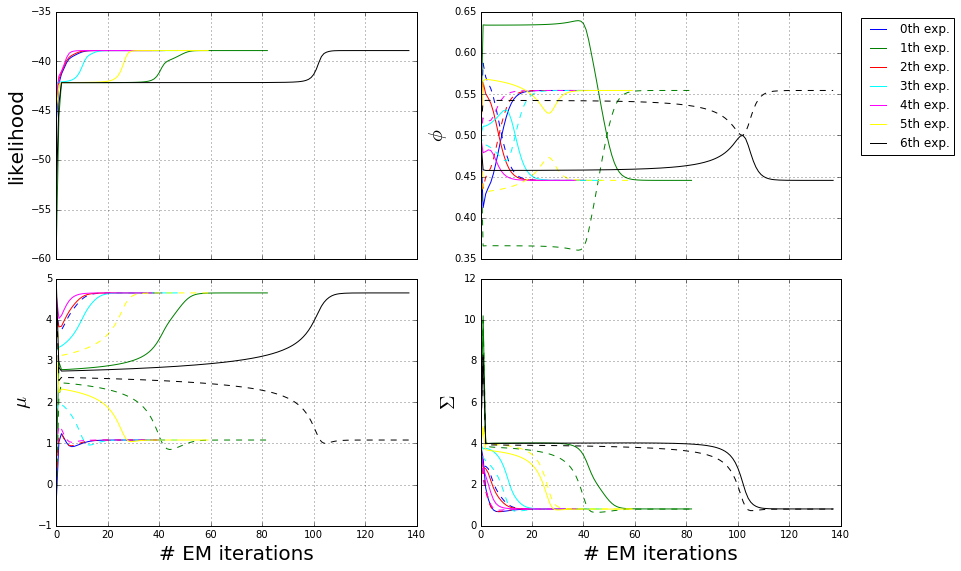

In [9]:
# to illustrate randomness, repeat the same experiment for 10 times,
# see how they converge
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(12, 8))
ax0, ax1, ax2, ax3 = axes.ravel()

num_gau=2
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
# colors = sns.color_palette("cubehelix", 10)
for k in range(len(colors)):
    ws_list, lkl_list, phis_list, mus_list, covars_list = em(Xs, num_gau=num_gau, convergence_cutoff=1e-12)

    xs = np.arange(len(lkl_list))
    ax0.plot(xs, lkl_list, color=colors[k], label='')
    ax0.set_ylabel('likelihood', fontsize=20)
    
    ax1.plot(xs, phis_list[:,0], color=colors[k], label='{0}th exp.'.format(k))
    ax1.plot(xs, phis_list[:,1], color=colors[k], ls='--', label='')
    ax1.set_ylabel('$\phi$', fontsize=20)

    ax2.plot(xs, mus_list[:,0], color=colors[k], label='')
    ax2.plot(xs, mus_list[:,1], color=colors[k], ls='--', label='')
#     ax2.plot(xs, np.full(xs.shape[0], mu0), color='black', alpha=0.5, lw=5)
#     ax2.plot(xs, np.full(xs.shape[0], mu1), color='black', alpha=0.5, lw=5)
    ax2.set_ylabel('$\mu$', fontsize=20)
    ax2.set_xlabel('# EM iterations', fontsize=20)
    
    ax3.plot(xs, covars_list[:,0].ravel(), color=colors[k], label='')
    ax3.plot(xs, covars_list[:,1].ravel(), color=colors[k], ls='--', label='')
    ax3.set_ylabel('$\Sigma$', fontsize=20)
    ax3.set_xlabel('# EM iterations', fontsize=20)
    
for _ in axes.ravel():
    _.grid()
ax1.legend(loc='upper left', bbox_to_anchor=(1.04,1))
plt.tight_layout()

**Insight**: 

1. Aside from that all experiments converge to the same maximum likelihood, this plot also shows that EM processes are guaranteed to increase the likelihood over each iteration, although some times the improvement seems to plateau for quite a while
1. It's a simple fitting, as $\phi$, $\mu$, and $\Sigma$ all converges to more or less of the same values. Dashed and solid lines represent the change of the properties over iterations. The convergence won't be as clean if the fitting is more ambiguous, or the likelihood function has more local optimas.

#### Plot the fitted Gaussians

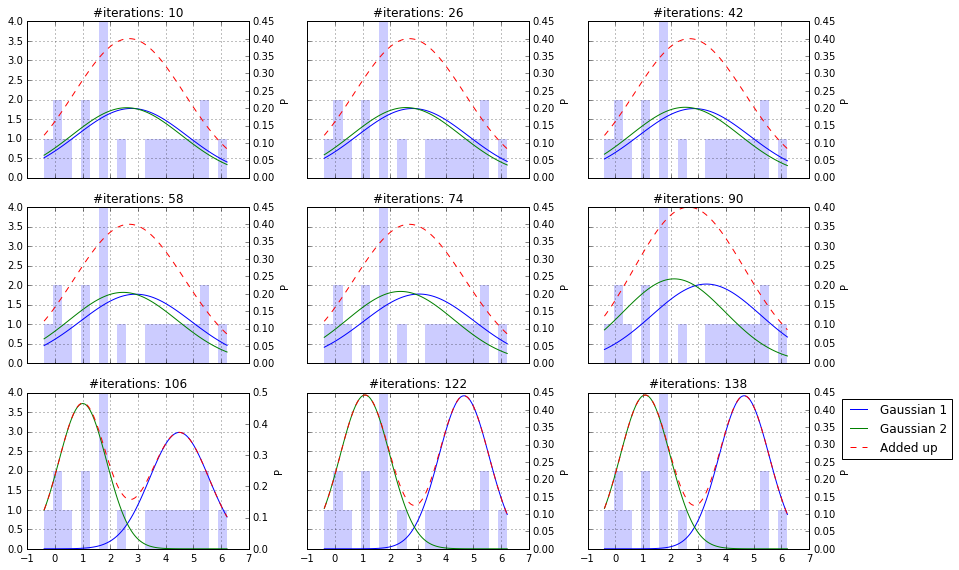

In [10]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 8))
axes = axes.ravel()

xs = np.linspace(min(Xs), max(Xs), 100)

n = 9
# make sure the result of the last iteration is included
idxes = np.arange(len(mus_list) - 1, -1, - len(mus_list) // n)[:n][::-1]

for k, idx in enumerate(idxes):
    ax = axes[k]
    ax.hist(Xs, bins=20, alpha=0.2, edgecolor='none', label='--')
    
    mu1, mu2 = mus_list[idx]
    covar1, covar2 = covars_list[idx].ravel()
    sigma1 = np.sqrt(covar1)
    sigma2 = np.sqrt(covar2)
    ax2 = ax.twinx()
    ax2.plot(xs, stats.norm.pdf(xs, mu1, sigma1), label='Gaussian 1')
    ax2.plot(xs, stats.norm.pdf(xs, mu2, sigma2), label='Gaussian 2')
    ax2.plot(xs, stats.norm.pdf(xs, mu1, sigma1) + 
             stats.norm.pdf(xs, mu2, sigma2), ls='--', label='Added up')
    ax.grid()
    ax.set_title('#iterations: {0}'.format(idx + 1)) 
    if k == 8:
        ax2.legend(loc='upper left', bbox_to_anchor=(1.12,1))
    
    ax2.set_ylabel('P')

plt.tight_layout()

Shown are the change of the fitted Gaussians over iterations, the final looks good!

Now trying to understand the meaning of $w$

In [11]:
ws = ws_list[-1]

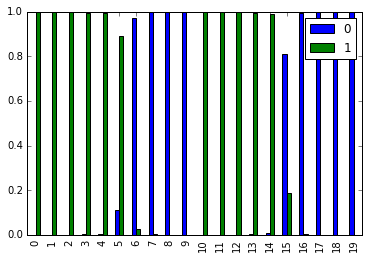

In [12]:
pd.DataFrame(ws.T).plot.bar()

$w$ is the probability of belonging a particular Gaussian given the data point, $w_j^{(i)} = p(z^{(i)} = j | x^{(i)}; \phi, \mu, \Sigma)$, but this is hard to verify here because the data is from a book, and I don't know the ground truth. The property of $w$ will be examined further in the 2D case next.

## First try with 2D data

In [13]:
mu_a = [10, 0]
cov_a = [[3, 1], [1, 4]]
size_a = 100

mu_b = [4, 0]
cov_b = [[3.5, 2], [2, 6.5]]
size_b = 100

In [14]:
Xa = np.random.multivariate_normal(mu_a, cov_a, size_a)
ya = np.zeros(size_a)
Xb = np.random.multivariate_normal(mu_b, cov_b, size_b)
yb = np.ones(size_b)
Xs = np.concatenate([Xa, Xb])
ys_true = np.concatenate([ya, yb])

Take a look at the mockup data

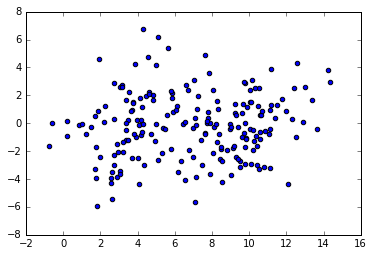

In [15]:
plt.scatter(Xs[:,0], Xs[:,1])

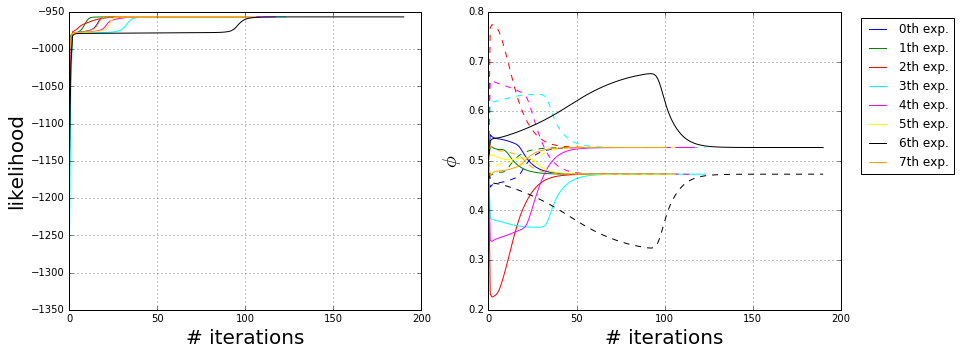

In [16]:
# to illustrate randomness, repeat the same experiment for 10 times,
# see how they converge
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))
ax0, ax1 = axes.ravel()

# fig = plt.figure(figsize=(8, 6))
# ax0 = fig.add_subplot(111)
num_gau=2
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']

mus_list_set = []
covars_list_set = []

for k in range(len(colors)):
    (ws_list,
     lkl_list, 
     phis_list,
     mus_list, 
     covars_list) = em(Xs, num_gau=num_gau, convergence_cutoff=1e-12)

    mus_list_set.append(mus_list)
    covars_list_set.append(covars_list)
    
    xs = np.arange(len(lkl_list))
    ax0.plot(xs, lkl_list, color=colors[k], label='')
    ax0.set_ylabel('likelihood', fontsize=20)
    
    ax1.plot(xs, phis_list[:,0], color=colors[k], label='{0}th exp.'.format(k))
    ax1.plot(xs, phis_list[:,1], color=colors[k], ls='--', label='')
    ax1.set_ylabel('$\phi$', fontsize=20)
    
    for _ax in [ax0, ax1]:
        _ax.set_xlabel('# iterations', fontsize=20)

for _ in axes.ravel():
    _.grid()
ax1.legend(loc='upper left', bbox_to_anchor=(1.04,1))
plt.tight_layout()

$\phi$ is about 0.5, which reflects the fact that the number of data points from each Gaussian is the same, i.e. 100.

Now show the movement of Gaussian means, with real means marked by crosses, the contours of the true Gaussians are also shown in light gray

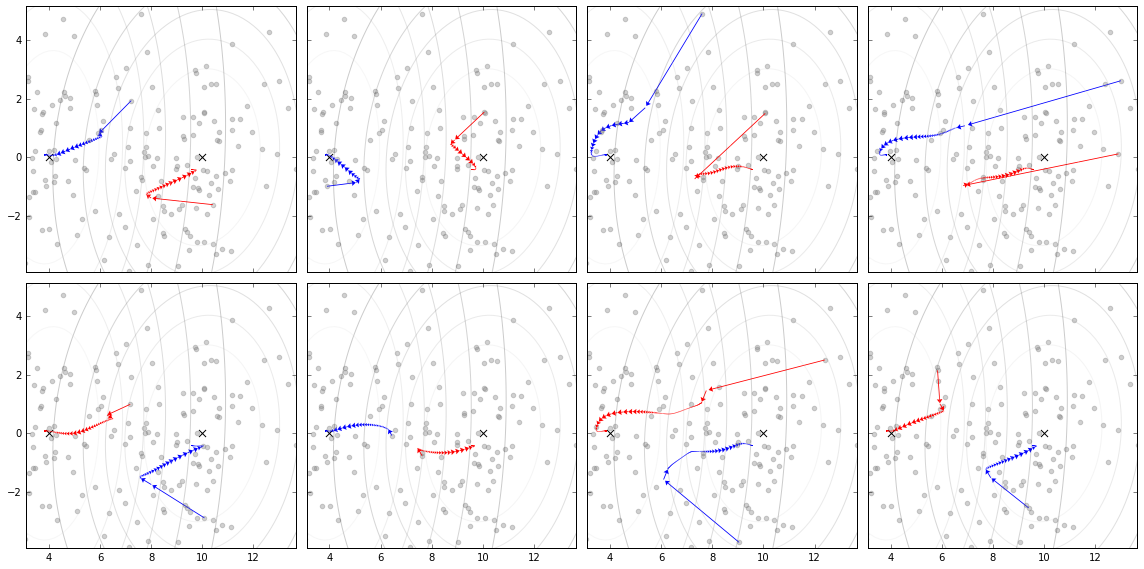

In [17]:
colors = ['blue', 'red']

fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(16, 8))
axes = axes.ravel()

xmin, ymin = np.array([(_[:,:,0].min(), _[:,:,1].min()) for _ in mus_list_set]).min(axis=0)
xmax, ymax = np.array([(_[:,:,0].max(), _[:,:,1].max()) for _ in mus_list_set]).max(axis=0)

xs = np.arange(-20, 20, 0.2)
ys = np.arange(-20, 20, 0.2)

X, Y = np.meshgrid(xs, ys)
Za = mlab.bivariate_normal(
    X, Y, sigmax=cov_a[0][0], sigmay=cov_a[1][1], mux=mu_a[0], muy=mu_a[1], sigmaxy=cov_a[0][1])
Zb = mlab.bivariate_normal(
    X, Y, sigmax=cov_b[0][0], sigmay=cov_b[1][1], mux=mu_b[0], muy=mu_b[1], sigmaxy=cov_b[0][1])
# Z = Za + Zb

for k, mus_list in enumerate(mus_list_set):
    ax = axes[k]
    ax.scatter(*mu_a, marker='x', color='black', s=50)
    ax.scatter(*mu_b, marker='x', color='black', s=50)
    cs = ax.contour(X, Y, Za, cmap='gray', alpha=0.2)
    cs = ax.contour(X, Y, Zb, cmap='gray', alpha=0.2)

    for j in range(num_gau):
        x, y = mus_list[:,j].T
        ax.scatter(Xs[:,0], Xs[:,1], color='gray', alpha=0.2)
        ax.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], color=colors[j],
                   scale_units='xy', angles='xy', scale=1.02, width=0.003, headwidth=7)
    ax.set_xlim(xmin - abs(xmin) * 0.05, xmax + abs(xmax) * 0.05)
    ax.set_ylim(ymin - abs(ymin) * 0.05, ymax + abs(ymax) * 0.05)
    
plt.tight_layout()

You could see the randomness beautifully, the estimated means of the two fitted Gaussians change over iterations (Each arrow is one iterration). Despite randomness, they converge to the real means often enough.

##### Now illustrate the variance change of a single experiment

In [18]:
ri = np.random.choice(np.arange(len(mus_list_set)))
mu_trajectory = mus_list_set[ri]
cov_trajectory = covars_list_set[ri]

n = 8 # number of snapshots from the trajectory to plot
idxes = np.arange(len(cov_trajectory) - 1, -1, - len(cov_trajectory) // n)[:n][::-1]
assert len(idxes) == 8

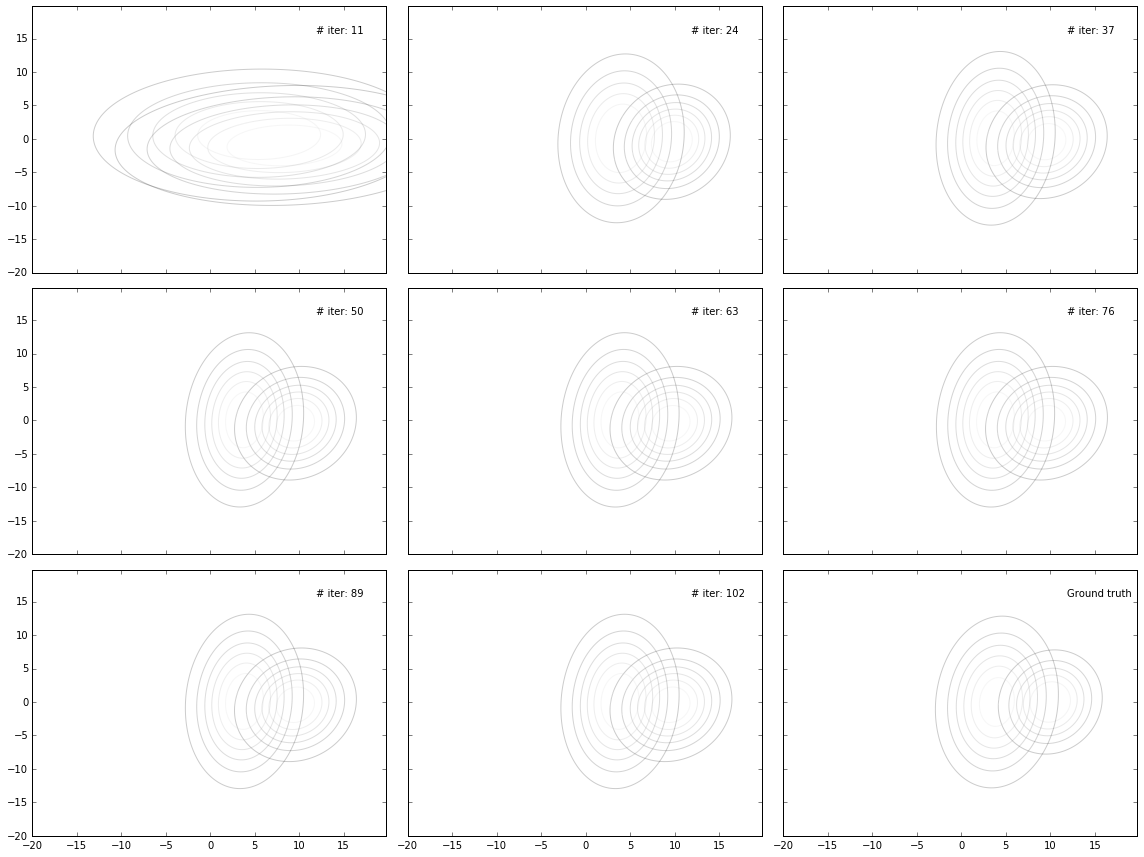

In [19]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(16, 12))
axes = axes.ravel()

xs = np.arange(-20, 20, 0.2)
ys = np.arange(-20, 20, 0.2)

X, Y = np.meshgrid(xs, ys)

for k, idx in enumerate(idxes):
    ax = axes[k]
    ma, mb = mu_trajectory[idx]
    ca, cb = cov_trajectory[idx]
    Za = mlab.bivariate_normal(
        X, Y, sigmax=ca[0][0], sigmay=ca[1][1], mux=ma[0], muy=ma[1], sigmaxy=ca[0][1])
    Zb = mlab.bivariate_normal(
        X, Y, sigmax=cb[0][0], sigmay=cb[1][1], mux=mb[0], muy=mb[1], sigmaxy=cb[0][1])

    ax.text(0.8, 0.9, '# iter: {0}'.format(idx + 1), transform=ax.transAxes)
    cs = ax.contour(X, Y, Za, cmap='gray', alpha=0.2)
    cs = ax.contour(X, Y, Zb, cmap='gray', alpha=0.2)

# plot the ground truth
lax = axes[-1]
Za = mlab.bivariate_normal(
    X, Y, sigmax=cov_a[0][0], sigmay=cov_a[1][1], mux=mu_a[0], muy=mu_a[1], sigmaxy=cov_a[0][1])
Zb = mlab.bivariate_normal(
    X, Y, sigmax=cov_b[0][0], sigmay=cov_b[1][1], mux=mu_b[0], muy=mu_b[1], sigmaxy=cov_b[0][1])
cs = lax.contour(X, Y, Za, cmap='gray', alpha=0.2)
cs = lax.contour(X, Y, Zb, cmap='gray', alpha=0.2)
lax.text(0.8, 0.9, 'Ground truth', transform=lax.transAxes)
plt.tight_layout()

As seen, the fitted two Gaussians are close to ground truth (Yay!), but no necessarily the same. Now, time to have a 🍺.

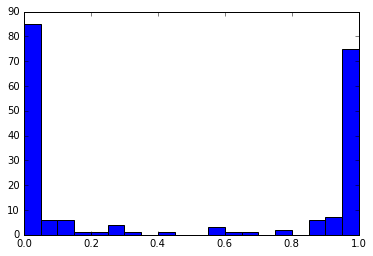

In [20]:
_ = plt.hist(ws_list[-1][1], bins=np.arange(0, 1.05, 0.05))

In [21]:
auroc = metrics.roc_auc_score(ys_true, ws_list[-1][0])
# because the two Gaussians are interchangable.
max(auroc, 1-auroc)

0.98839999999999995

As you could see, $w$ obtained from EM can be used to predict which Gaussian does a data point likely come from.

I am not sure how Gaussian discriminant analysis exactly works yet, but this is likely what it is about.

## Try 3 Gaussians

In [22]:
mu_a = [10, 0]
cov_a = [[3, 1], [1, 4]]
size_a = 100

mu_b = [4, 0]
cov_b = [[3.5, 2], [2, 6.5]]
size_b = 100

mu_c = [6, 4]
cov_c = [[3.5, 2], [2, 2]]
size_c = 200    # not balanced

In [23]:
Xa = np.random.multivariate_normal(mu_a, cov_a, size_a)
Xb = np.random.multivariate_normal(mu_b, cov_b, size_b)
Xc = np.random.multivariate_normal(mu_c, cov_c, size_c)
Xs = np.concatenate([Xa, Xb, Xc])

Take a look at the mockup data

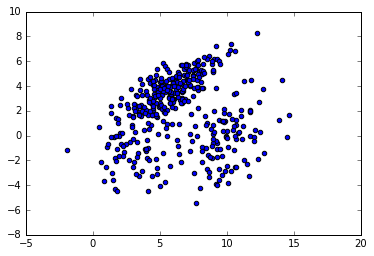

In [24]:
plt.scatter(Xs[:,0], Xs[:,1])

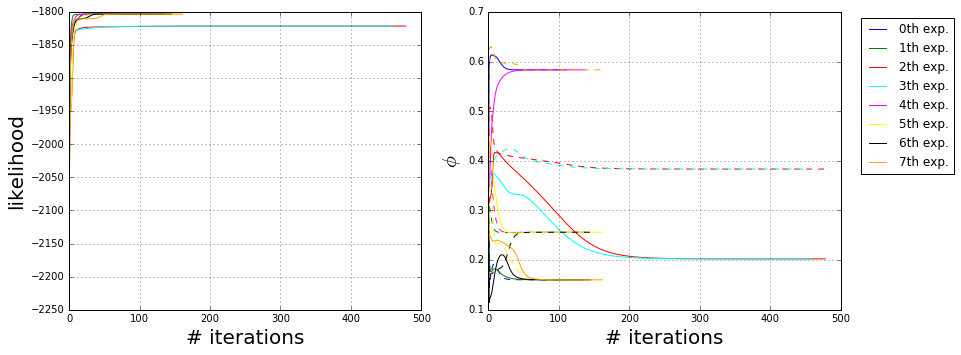

In [25]:
# to illustrate randomness, repeat the same experiment for 10 times,
# see how they converge
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))
ax0, ax1 = axes.ravel()

# fig = plt.figure(figsize=(8, 6))
# ax0 = fig.add_subplot(111)
num_gau=3
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']

mus_list_set = []
covars_list_set = []

for k in range(len(colors)):
    (ws_list,
     lkl_list, 
     phis_list,
     mus_list, 
     covars_list) = em(Xs, num_gau=num_gau, convergence_cutoff=1e-12)

    mus_list_set.append(mus_list)
    covars_list_set.append(covars_list)
    
    xs = np.arange(len(lkl_list))
    ax0.plot(xs, lkl_list, color=colors[k], label='')
    ax0.set_ylabel('likelihood', fontsize=20)
    
    ax1.plot(xs, phis_list[:,0], color=colors[k], label='{0}th exp.'.format(k))
    ax1.plot(xs, phis_list[:,1], color=colors[k], ls='--', label='')
    ax1.set_ylabel('$\phi$', fontsize=20)
    for _ax in [ax0, ax1]:
        _ax.set_xlabel('# iterations', fontsize=20)
    
for _ in axes.ravel():
    _.grid()
ax1.legend(loc='upper left', bbox_to_anchor=(1.04,1))
plt.tight_layout()

Now show the movement of Gaussian means, with real means marked by crosses, the contours of the true Gaussians are also shown in light gray

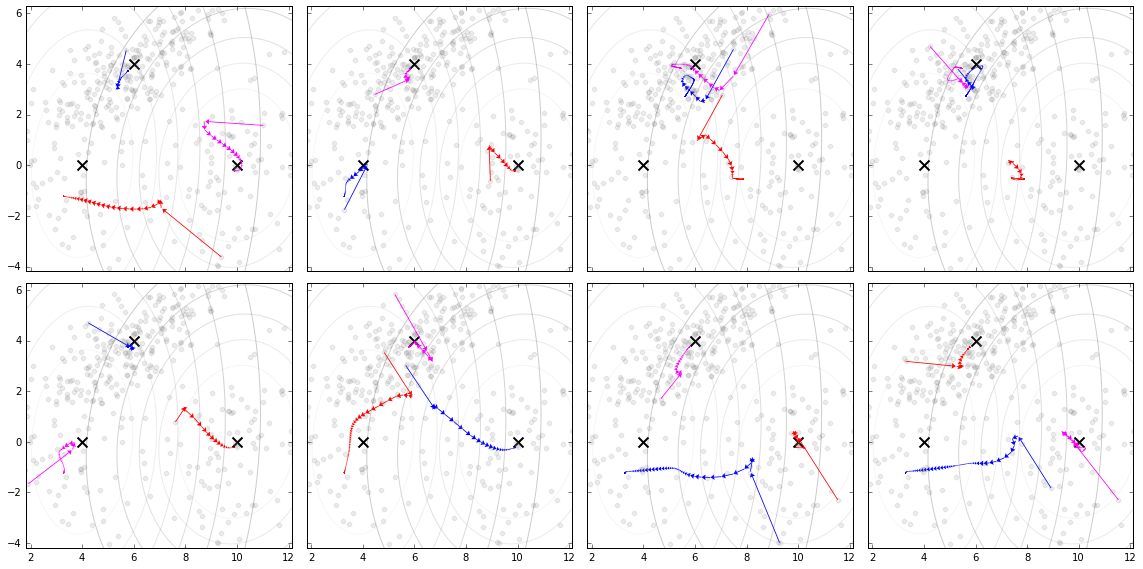

In [26]:
colors = ['blue', 'red', 'magenta']

fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(16, 8))
axes = axes.ravel()

xmin, ymin = np.array([(_[:,:,0].min(), _[:,:,1].min()) for _ in mus_list_set]).min(axis=0)
xmax, ymax = np.array([(_[:,:,0].max(), _[:,:,1].max()) for _ in mus_list_set]).max(axis=0)

xs = np.arange(-20, 20, 0.2)
ys = np.arange(-20, 20, 0.2)

X, Y = np.meshgrid(xs, ys)
Za = mlab.bivariate_normal(
    X, Y, sigmax=cov_a[0][0], sigmay=cov_a[1][1], mux=mu_a[0], muy=mu_a[1], sigmaxy=cov_a[0][1])
Zb = mlab.bivariate_normal(
    X, Y, sigmax=cov_b[0][0], sigmay=cov_b[1][1], mux=mu_b[0], muy=mu_b[1], sigmaxy=cov_b[0][1])
# Z = Za + Zb

for k, mus_list in enumerate(mus_list_set):
    ax = axes[k]
    for _mu in [mu_a, mu_b, mu_c]:
        ax.scatter(*_mu, marker='x', color='black', lw=2, s=100)
    cs = ax.contour(X, Y, Za, cmap='gray', alpha=0.2)
    cs = ax.contour(X, Y, Zb, cmap='gray', alpha=0.2)

    for j in range(num_gau):
        x, y = mus_list[:,j].T
        ax.scatter(Xs[:,0], Xs[:,1], color='gray', alpha=0.05)
        ax.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], color=colors[j],
                   scale_units='xy', angles='xy', scale=1.02, width=0.003, headwidth=7)
    ax.set_xlim(xmin - abs(xmin) * 0.05, xmax + abs(xmax) * 0.05)
    ax.set_ylim(ymin - abs(ymin) * 0.05, ymax + abs(ymax) * 0.05)
    
plt.tight_layout()

You could see the randomness beautifully, the estimated means of the two fitted Gaussians change over iterations (Each arrow is one iterration). Despite randomness, they converge to the real means often enough. But sometimes it also get messed up (e.g. unlucky simulation)

##### Now illustrate the variance change of a single experiment

In [27]:
ri = np.random.choice(np.arange(len(mus_list_set)))
mu_trajectory = mus_list_set[ri]
cov_trajectory = covars_list_set[ri]

n = 8 # number of snapshots from the trajectory to plot
idxes = np.arange(len(cov_trajectory) - 1, -1, - len(cov_trajectory) // n)[:n][::-1]
assert len(idxes) == 8

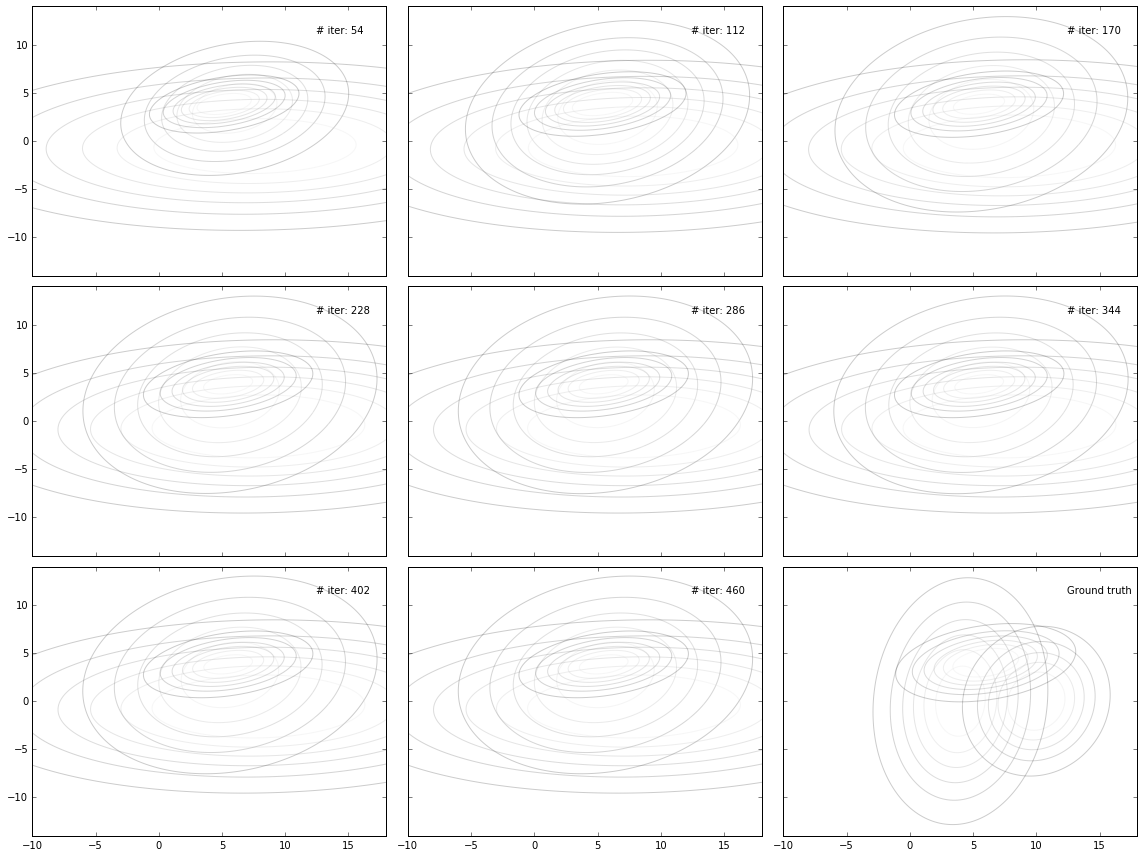

In [28]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(16, 12))
axes = axes.ravel()

xs = np.arange(-20, 20, 0.2)
ys = np.arange(-20, 20, 0.2)

X, Y = np.meshgrid(xs, ys)

for k, idx in enumerate(idxes):
    ax = axes[k]
    ms = mu_trajectory[idx]
    cs = cov_trajectory[idx]
    
    for mi, ci in zip(ms, cs):
        Zi = mlab.bivariate_normal(
            X, Y, sigmax=ci[0][0], sigmay=ci[1][1], mux=mi[0], muy=mi[1], sigmaxy=ci[0][1])
        cs = ax.contour(X, Y, Zi, cmap='gray', alpha=0.2)

    ax.text(0.8, 0.9, '# iter: {0}'.format(idx + 1), transform=ax.transAxes)
    ax.set_xlim(-10, 18)
    ax.set_ylim(-14, 14)

# plot the ground truth
lax = axes[-1]
for mi, ci in zip([mu_a, mu_b, mu_c], [cov_a, cov_b, cov_c]):
    Zi = mlab.bivariate_normal(
        X, Y, sigmax=ci[0][0], sigmay=ci[1][1], mux=mi[0], muy=mi[1], sigmaxy=ci[0][1])
    cs = lax.contour(X, Y, Zi, cmap='gray', alpha=0.2)

lax.text(0.8, 0.9, 'Ground truth', transform=lax.transAxes)
plt.tight_layout()

As seen, the fitted Gaussians are close to ground truth (Yay!), but no necessarily the same. Now, time to have a 🍺.